# Modelo 1 - Modelo/Motor de Recomendacion de vinos  -- `Wine Me App!`

Fecha de creacion: 2024/04/11

Ultima fecha de actualizacion de este documento: 2024/04/19 - por María Pérez Sebastián

- **Objetivo general de este modelo** : 

obtener un `sistema de recomendacion de vinos` a partir del `input del usuario`. La idea seria que este motor estuviera en la seccion de vinos de unos grandes almacenes/supermercados, o bien en una tablet en un restaurante cuando vamos a pedir bebidas - Esto seria equivalente al trabajo de un soumelier-. El usuario, conociendo el nombre de un vino que le gusta, podria preguntarle al recomendador por vinos similares al vino conocido. La recomendacion se basa en similitudes de cosenos para generar las recomedaciones. Las similitudes las hemos determinado exclusivamente en notas de cata y maridaje y por tanto necesitamos de algorirmos de Procesamiento del Lenguaje Natural (NLP).

Entendemos que estas caracteristicas pueden ser muy utiles para los usuarios, ya que si conoces un vino que te gusta, solo buscaremos recomendaciones en sus caracteristicas organolepticas (visuales, olfativas y gustativas) y para acompañamientos similares de alimentos. Ejemplos de notas de cata tipicas y maridajes por tipo de vino:

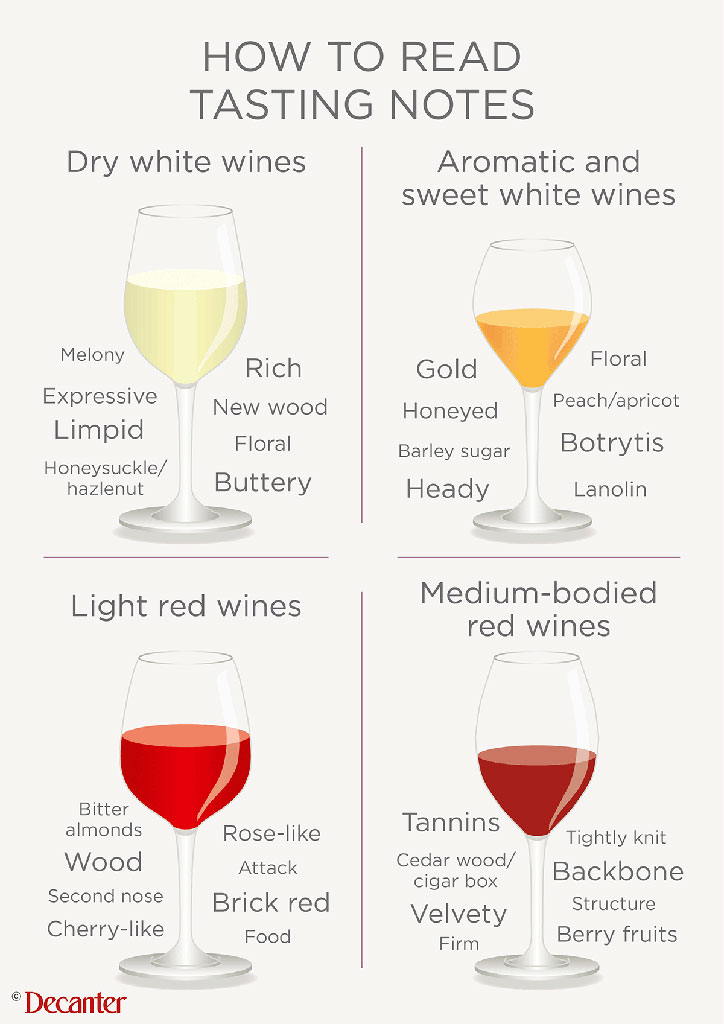

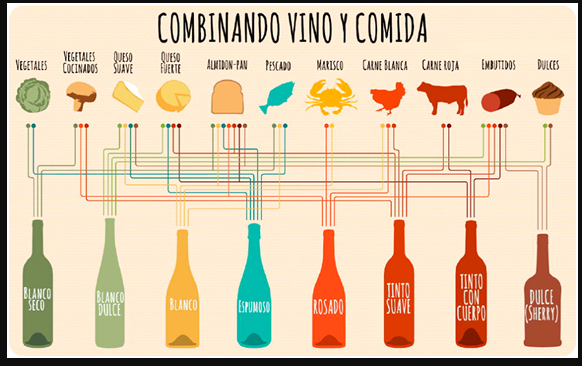


- **Metodos generales del sistema de recomendacion**: 

    - 1. **Web Scrapping**: Hemos sacado todos los 4800 vinos españoles disponibles en la pagina web `bodeboca.como` utilizando paquetes como `beatiful soup`
    - 2. **Preprocesamiento**: Hemos limpiado, revisado NAs del dataset. Despues para las variables/columnas tipo string, hemos pasado a minuscula, limpiado de `stop words` oficiales del castellano, y otras personalizadas que creamos para cada columna, normalizado, tokenizado y lematizado para tener los strings mas limpios (procesamiento de NLP).
    - 3. **EDA**: Hemos revisado los datos haciendo un `EXploratory Data Analysis`
    - 4. **Modelos de recomendacion**: 
        - Una vez normalizado el texto de cata y maridaje, los unimos en una columna: `descripcion` que sera la que usemos como elemento del vino a evaluar. 
        - Utilizamos un modelo preentrenado (transfer learning: `Google Universal Sentence Encoder version 4 (USE)`), para convertir las notas de cata y maridaje (`descripcion`), en vectores de 512 dimensiones para capturar el significado semántico. El USE utiliza una arquitectura de redes neuronales profundas entrenada en grandes corpus de texto.
        - Por último, utilizamos `similitudes de coseno` entre dos vectores que representan vinos para calcular los valores de similitud entre ellos. Esto es lo que usamos para la recomendacion, obteniendo aquellos con el valor más cercano a 1 y así determinar los vinos más afines en función de cata y maridaje.


In [1]:
# Cargamos librerias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from unidecode import unidecode  


from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import surprise
from surprise import BaselineOnly, Dataset, Reader

import warnings
warnings.filterwarnings('ignore')


import cloudpickle
from tqdm import tqdm
import tensorflow_hub as hub
import numpy as np
from sklearn.manifold import TSNE
import tensorflow as tf 
import math 

## 1. Cargamos el dataset

Cargamos el dataframe de los vinos `df_vinos_raw2.csv` que contiene las siguientes columnas:

- titulo: La columna `titulo` contiene el nombre del vino extraido de la pagina bodeboca.com
- link: La columna `link` contiene el link de bodeboca.com para ese vino
- precio: la columna `precio` contiene el precio del vino en abril 2024
- rating: La columna `rating` contiene el rating o valoracion del vino bien por los usuarios de bodeboca.com o de multiples usuarios evaluado en Google u otras paginas de vinos como vinissimuss.com
- bodega: la columna `bodega` contiene el nombre de la bodega a la que pertenece el vino
- tipo: la columna `tipo` contiene la categoria del vino a la que pertenece (), estas pueden ser las siguientes: array(['tinto', 'red vermouth', 'blanco', 'espumoso', 'amontillado', 'oloroso', 'tinto reserva', 'blanco fermentado en barrica', 'white vermouth', 'manzanilla', 'dulce px', 'palo cortado', 'palo cortado vors', 'fino', 'rosado', 'otro(s)', 'tinto joven','tinto crianza', 'amontillado vors', 'oloroso vors','aromatised wine', 'blanco naturalmente dulce', 'tinto dulce', 'blanco dulce', 'orange wine', 'tinto gran reserva', 'cava','sweet moscatel', 'oloroso dulce', 'dulce px vors', 'frizzante','rueda dorado', 'vermut dorado', 'vermouth', 'dulce', 'rancio'],dtype=object)
- grado: la columna `grado` contiene la graduacion en alcohol del vino
- anada: la columna `anada` contiene el año del vino o la añada
- variedad: la columna `variedad` contiene la variedad de uva y sus porcentajes para cada vino
- origen: la coluna `origen` contiene informacion del lugar del que procede el vino
- vista: la coluna `vista` contiene informacion sobre las caracteristicas visuales del vino
- nariz: la coluna `nariz` contiene informacion sobre las caracteristicas olfativas del vino
- boca: la coluna `boca` contiene informacion sobre las caracteristicas gustativas del vino
- temp_servir : la coluna `temp_servir` contiene informacion sobre recomendaciones de temperatura de servicio del vino
- maridaje: la coluna `maridaje` contiene informacion sobre recomendaciones de maridaje/acompanamiento del vino
- clima: la coluna `clima` contiene informacion sobre el clima del lugar donde se producen las cepas del vino
- suelo: la coluna `suelo` contiene informacion sobre el suelo del lugar donde se producen las cepas del vino
- envejecimiento: la coluna `envejecimiento` contiene informacion sobre la crianza del vino
- tipo2: la columna `tipo2` es una variacion de la columna `tipo`. En `tipo2` hemos hecho un reagrupamiento de los tipos en solo 6 clases: tinto, vermouth, blanco, espumoso, generoso, rosado
- variedad2:  la columna `variedad2` es una variacion de la columna `variedad`. En `variedad2` hemos extraido solamente el texto de las variedades de uva y eliminado los %
- cata: la columna `cata` contiene la informacion de cata del vino (vista + nariz + boca)
- fisico: la columna `fisico` contiene la union de la informacion de clima y suelo
- descripcion: la columna `descripcion` contiene la informacion de notas de cata (vista + nariz + boca) mas las notas de maridaje
- descripcion2: la columna `descripcion2` contiene la informacion de la columna `descripcion` donde hemos eliminado stopwords, normalizado, tokenizado y lematizado el texto haciendo un tratamiento de NLP para cada vino 
- fisico2: la columna `fisco2` es una variacion de la columna `fisico`, donde hemos eliminado stopwords, normalizado, tokenizado y lematizado el string de cata para cada vino


In [2]:
import os
current_directory = os.getcwd()
print("El directorio de trabajo actual es:", current_directory)

El directorio de trabajo actual es: C:\Users\FUSA\Documents\ID_BOOTCAMP\_PROYECTO VINOS\00_Proyecto_vino\Github final\Notebooks


In [4]:
# Cargamos los datos
data = pd.read_csv('df_vinos_modelos.csv')
print(data.shape) # el dataset tiene 4792 vinos y 25 columnas

data.T

(4792, 25)


0     \
titulo                               sierra cantabria magico 2016   
link            https://bodeboca.com/vino/sierra-cantabria-mag...   
precio                                                      594.0   
rating                                                        5.0   
bodega                           bodegas vinedos-sierra-cantabria   
tipo                                                        tinto   
grado                                                        14.5   
anada                                                      2016.0   
variedad        65% tempranillo, 20% garnacha, 4.4% calagraño,...   
origen                                                      rioja   
vista           rojo cereza / reflejos violaceos / capa media-...   
nariz           embriagante / delicado / fruta roja / regaliz ...   
boca                          fino / sutil / sorprendente / largo   
temp_servir                                                  16.0   
maridaje                                 lechazo / aves / ternera   
clima                     continental con influencia mediterranea   
suelo                            arcillo-limoso / arcillo-arenoso   
envejecimiento       crianza en barricas nuevas de roble frances.   
tipo2                                                       tinto   
variedad2        tempranillo,  garnacha,  calagraño,  turrunte...   
cata            rojo cereza / reflejos violaceos / capa media-...   
fisico          continental con influencia mediterranea arcill...   
descripcion     rojo cereza / reflejos violaceos / capa media-...   
descripcion2    rojo cereza reflejos violaceos capa medium alt...   
fisico2         continental influencia mediterranea arcillo li...   

                                                             1     \
titulo                                         viña el pison 2019   
link                 https://bodeboca.com/vino/vina-el-pison-2019   
precio                                                      375.0   
rating                                                        5.0   
bodega                               bodegas artadi-vinedos-vinos   
tipo                                                        tinto   
grado                                                        14.5   
anada                                                      2019.0   
variedad                                         100% tempranillo   
origen                                             vino de españa   
vista           bien definidos, nitidos y transparentes cromat...   
nariz           notas de regaliz, anises y frutas citricas fre...   
boca            poderosos pero sutiles, con una textura esbelt...   
temp_servir                                                  16.0   
maridaje        carnes rojas asadas y a la parrilla, caza mayo...   
clima                        atlantico con influencia continental   
suelo                                            arcillo-calcareo   
envejecimiento           crianza de 8 meses en barricas de roble.   
tipo2                                                       tinto   
variedad2                                             tempranillo   
cata            bien definidos, nitidos y transparentes cromat...   
fisico          atlantico con influencia continental arcillo-c...   
descripcion     bien definidos, nitidos y transparentes cromat...   
descripcion2    bien definidos nitidos transparentes cromatica...   
fisico2         atlantico influencia continental arcillo calcareo   

                                                             2     \
titulo                         artadi la poza de ballesteros 2020   
link            https://bodeboca.com/vino/artadi-la-poza-balle...   
precio                                                      105.0   
rating                                                        4.7   
bodega                               bodegas artadi-vinedos-vinos   
tipo                                                     

In [5]:
data.columns


Index(['titulo', 'link', 'precio', 'rating', 'bodega', 'tipo', 'grado',
       'anada', 'variedad', 'origen', 'vista', 'nariz', 'boca', 'temp_servir ',
       'maridaje', 'clima', 'suelo', 'envejecimiento', 'tipo2', 'variedad2',
       'cata', 'fisico', 'descripcion', 'descripcion2', 'fisico2'],
      dtype='object')

## 2. Modelo de recomendacion de vinos - basado en notas de `cata` y `maridaje`

En primer lugar, vamos a utilizar un modelo preentrenado (transfer learning), para convertir las notas de cata y maridaje (`descripcion`), que están en formato texto, a vectores numéricos. Esto es lo que nos va a permitir encontrar recomendaciones. Al final este proceso es una vectorizacion similar al `CountVectorizer` de sklearn.

Para ello, usaremos el `Google Universal Sentence Encoder version 4`, que está disponible en el TensorFlow hub y que convierte cualquier en cualquiera de los siguientes idiomas: Inglés, Español, Francés, Alemán, Italiano, Portugués, Ruso, Chino (simplificado y tradicional), Árabe, Hindi, Japonés y Coreano; en un vector de 512 dimensiones o sentence embedding.

El Universal Sentence Encoder (USE) transforma texto en vectores de 512 dimensiones para capturar el significado semántico. Esta dimensionalidad fue elegida por su equilibrio entre la representación semántica y la eficiencia computacional, permitiendo que el modelo generalice bien en una variedad de tareas de procesamiento de lenguaje natural (NLP).

### 1.1. Creamos encodings para las notas de cata y maridaje (`descripcion`)

Me ha dado un error despues de utilizarlo millones de veces antes:
`ValueError: Trying to load a model of incompatible/unknown type. 'C:\Users\Soraya\AppData\Local\Temp\tfhub_modules\063d866c06683311b44b4992fd46003be952409c' contains neither 'saved_model.pb' nor 'saved_model.pbtxt'.`

Se soluciona accediendo a la direccion donde se supone que se aloja el modelo, eliminando el contendio se soluciona:
https://github.com/tensorflow/hub/issues/896


In [6]:
# creamos los EMBEDDINGS para descripcion = cata + maridaje
create_embeddings = True

if create_embeddings:
    use = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
    
    # Raw embeddings
    EMBEDDINGS = [] 
    
    for i in tqdm(data['descripcion2'].tolist()):
        EMBEDDINGS.append(use([i]))
    
    EMBEDDINGS = np.array(EMBEDDINGS)
    EMBEDDINGS = EMBEDDINGS.reshape([EMBEDDINGS.shape[0], EMBEDDINGS.shape[2]])
    
    #cloudpickle.dump(EMBEDDINGS, open('C:/Users/Soraya/Documents/ID Bootcamps Data Science/08. Proyecto final/3. Modelos/wine_embeddings.p','wb'))
else:
    #EMBEDDINGS = cloudpickle.load(open('C:/Users/Soraya/Documents/ID Bootcamps Data Science/08. Proyecto final/3. Modelos/wine_embeddings.p','rb'))
    EMBEDDINGS = np.array(EMBEDDINGS)
    EMBEDDINGS = EMBEDDINGS.reshape([EMBEDDINGS.shape[0], EMBEDDINGS.shape[2]])


100%|██████████| 4792/4792 [00:16<00:00, 298.02it/s]


In [6]:
# Podemos comprobar que los embeddings están normalizados. Esto es importante de cara a calcular su similitud para obtener recomendaciones.
sum(EMBEDDINGS[0,:]**2)

NameError: name 'EMBEDDINGS' is not defined

###  1.2 Similitudes de coseno para generar recomendaciones

Vamos a usar unas funciones que toman dos conjuntos de vectores, calculan la similitud del coseno entre dos vectores de texto y devuelven las incrustaciones más similares a una consulta dada. Son útiles para tareas de recomendación basadas en similitud de texto.

En nuestro caso concreto, una vez transformadas todas las notas de cata en vectores, podemos utilizar la similitud del coseno para obtener aquellos vectores más cercanos a uno dado usando la siguiente fórmula, donde A y B serian los vinos a evaluar:

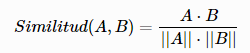

En este caso, nosotros lo transformaremos en una puntuación siguiendo las indicaciones para similitud textual del benchmark STS. En el contexto del benchmark STS (Semantic Textual Similarity), los puntajes de similitud del coseno se miden típicamente en un rango de 0 a 1, donde:

- 0: Indica ninguna similitud entre los dos vectores de texto. Esto significa que los vectores son completamente diferentes y no comparten ninguna similitud semántica.
- 1: Indica una similitud perfecta entre los dos vectores de texto. Esto significa que los vectores son idénticos o muy similares en términos de contenido semántico.

En resumen, los puntajes de similitud del coseno en el benchmark STS proporcionan una medida de la similitud semántica entre dos textos, en nuestro caso las notas de cata y maridaje del vino `A` y las mismas del vino `B`, donde un puntaje más alto indica una mayor similitud y un puntaje más bajo indica una menor similitud.

In [44]:
# creamos las funciones para el motor de recomendacion
def compute_scores(a, b):
    '''
    Esta función calcula la similitud de coseno entre dos conjuntos de vectores normalizados utilizando TensorFlow. 
    
    Input: La función espera dos tensores a y b, donde cada uno representa un conjunto de vectores. Se espera que estos vectores ya estén normalizados en la dimensión 1.
    Output: puntuación de similitud para cada par de vectores de los conjuntos a y b. La puntuación se calcula como la similitud de coseno entre los vectores
    correspondientes en a y b. Se realiza un ajuste adicional para asegurarse de que las similitudes estén dentro del rango [-1, 1], y luego se convierten en puntajes de similitud en el rango [0, 1].
    '''
    a = tf.nn.l2_normalize(a, axis=1)
    b = tf.nn.l2_normalize(b, axis=1)
    cosine_similarities = tf.matmul(a, b, transpose_b = True)
    clip_cosine_similarities = tf.clip_by_value(cosine_similarities, -1.0, 1.0)
    scores = 1.0 - tf.acos(clip_cosine_similarities) / math.pi
    return scores


def get_recommendations(query, embeddings, top_k = 10):
    '''
    Esta función proporciona recomendaciones basadas en similitud de coseno entre un vector de consulta, vino que introducimos del dataset, y una matriz de vectores de incrustación (los embeddings)
    
    Input: La función espera tres argumentos:
        - query: Un vector de consulta, el vino que queramos buscar por posicion del index, que puede ser un único vector o una matriz de vectores
        - embeddings: Una matriz de vectores de incrustación donde se buscarán similitudes con el vector de consulta
        - top_k: El número de elementos más similares que se devolverán como recomendaciones (por defecto es 10), podemos modificarlo.
    '''
    if len(query.shape)==1:
        query = tf.expand_dims(query, 0)
    sim_matrix = compute_scores(query, embeddings)
    rank = tf.math.top_k(sim_matrix, top_k)
    return rank



## 3. Prueba motor de recomendacion de vinos para 1 o varios vinos del dataset

Aplicando las funciones anteriores podemos buscar la recomendacion para un vino rosado `Valdiniebla clarete 2021` que esta en el index 96. 

El query, tiene que ser la fila del dataset de embeddings (recuerda que son los 512 vectores que representan las palabras mas importantes de notas de cata y maridaje) que representa cada vino por lo que podemos llamarlo por su index.

Segun tenemos el codigo, el primer vino siempre sera el que introducimos en la busqueda.

In [97]:
# EJEMPLO
# # Vamos a probar con un vino rosado valdiniebla clarete 2021 --posicion 96
scores, rank = get_recommendations(EMBEDDINGS[(96),:], EMBEDDINGS, top_k = 5)
recomendaciones = data.iloc[rank.numpy().reshape(-1).tolist(), :]
    
# Crear una nueva columna en el DataFrame recomendaciones para almacenar los scores de cada vino en STS
lista_de_listas = scores.numpy().tolist()
lista_scores = [elemento for sublista in lista_de_listas for elemento in sublista]
recomendaciones["Score_similitud"] = lista_scores

recomendaciones

titulo  \
96          la bota de florpower 97 mmxviii   
542                       cream el trovador   
3957    visol brut nature gran reserva 2017   
2015                        alfonso oloroso   
167   manzanilla pago callejuela 2016 50 cl   

                                                   link  precio  rating  \
96    https://bodeboca.com/vino/la-bota-florpower-97...    28.5     3.9   
542         https://bodeboca.com/vino/cream-el-trovador    12.5     3.5   
3957  https://bodeboca.com/vino/visol-brut-nature-gr...    25.9     4.1   
2015          https://bodeboca.com/vino/alfonso-oloroso    10.5     4.0   
167   https://bodeboca.com/vino/manzanilla-pago-call...    30.7     3.0   

                                   bodega        tipo  grado   anada  \
96                 bodegas equipo-navazos     otro(s)   12.0  2018.0   
542   bodegas bodegas-primitivo-collantes     otro(s)   17.5     NaN   
3957                      bodegas mestres        cava   12.0  2017.0   
2015               bodegas gonzalez-byass     oloroso   18.0     NaN   
167                    bodegas callejuela  manzanilla   16.0  2016.0   

                             variedad                            origen  ...  \
96                 100% palomino fino                    vino de españa  ...   
542   75% palomino fino, 25% moscatel                jerez-xeres-sherry  ...   
3957    xareli·lo, macabeo, parellada                              cava  ...   
2015               100% palomino fino                jerez-xeres-sherry  ...   
167                100% palomino fino  manzanilla-sanlucar de barrameda  ...   

                                                  suelo  \
96                                             albariza   
542                                            albariza   
3957  de tipo franco-arcilloso y calizo, que permite...   
2015                                 calcareo albarizo.   
167                                           albariza.   

                                         envejecimiento     tipo2  \
96                                                  NaN  generoso   
542   crianza oxidativa (cabeceo de vino seco y vino...  generoso   
3957  mas de 5 años de crianza en rima. se realizaro...  espumoso   
2015  mi­nimo 8 años en botas de roble americano sig...  generoso   
167                                                 NaN  generoso   

                         variedad2  \
96                   palomino fino   
542       palomino fino,  moscatel   
3957  xarelilo, macabeo, parellada   
2015                 palomino fino   
167                  palomino fino   

                                                   cata  \
96    amarillo dorado, con ligera turbidez natural f...   
542   amarillo dorado, con ligera turbidez natural f...   
3957  de color amarillo pajizo y con fini­sima burbu...   
2015  color ambar oro. intensos aromas calidos y red...   
167   amarillo de capa alta nariz compacta pero bast...   

                                                 fisico  \
96    el clima meridional se compensa con el atlanti...   
542                                  atlantico albariza   
3957  mediterraneo. el año 2017 se caracterizo por c...   
2015  el otoño y el invierno son, por lo general, su...   
167                                 atlantico albariza.   

                                            descripcion  \
96    amarillo dorado, con ligera turbidez natural f...   
542   amarillo dorado, con ligera turbidez natural f...   
3957  de color amarillo pajizo y con fini­sima burbu...   
2015  color ambar oro. intensos aromas calidos y red...   
167   amarillo de capa alta nariz compacta pero bast...   

                                           descripcion2  \
96    amarillo dorado ligera turbidez natural frutos...   
542   amarillo dorado ligera turbidez natural frutos...   
3957  color amarillo pajizo fini sima burbuja aporte...   
2015  color ambar oro intensos aroma calidos redondo...   
167   amarillo capa alta nariz

### 3.1 Recomendaciones para 3 vinos a la vez

En la query podemos meter no solo un vino `a` con la posicion/fila de los EMBEDDINGS[a, :], tambien podemos buscar las top_k recomendaciones para n-vinos asi: EMBEDDINGS[(a,b,..,n), :], aunque lo que hace realmente es sacar los vinos recomendados uno encima de otro. Hace por asi decirlo como un stacking de recomendaciones. Recuerda que con nuestro codigo el primer vino siempre es el que le metemos en la busqueda para tener como referencia.

De la lista de recomendaciones, sacariamos los vinos de la busqueda. A continuacion, calculariamos la media de los `scores de similitud` y podriamos sacar como recomendacion aquiellos vinos que tuvieran un score de similitud en torno al valor de la media.

Esto seria una opcion para difentes vinos, aunque seguro que hay opciones mas limpias y matematicamente mas finas.

In [1]:
# Ejemplo con 3 vinos rosados 
# # Vamos a probar con un vino rosado valdiniebla clarete 2021 --posicion 96
# la rosa 2022 -- posicion 111, y ondipuerko rosado 2020 --> posicion 148
scores, rank = get_recommendations(EMBEDDINGS[(96, 111, 148),:], EMBEDDINGS, top_k = 5)
recomendaciones = data.iloc[rank.numpy().reshape(-1).tolist(), :]
    
# Crear una nueva columna en el DataFrame recomendaciones para almacenar los scores de cada vino en STS
lista_de_listas = scores.numpy().tolist()
lista_scores = [elemento for sublista in lista_de_listas for elemento in sublista]
recomendaciones["Score_similitud"] = lista_scores

recomendaciones

NameError: name 'get_recommendations' is not defined

In [10]:
# Como los vinos de las busquedas se colocan arriba de cada 5 vinos, eliminamos los vinos buscados asi
indices_a_eliminar = [0, 5, 10]

# Eliminar las filas en las posiciones especificadas
# necesitamos resetear los indices porque sino mantienen los del dataset original
recomendaciones2 = recomendaciones.reset_index().drop(indices_a_eliminar)

recomendaciones2.sort_values(by = "Score_similitud", ascending = False)

# calculamos la media del score de similitud de los vinos seleccionados
round(recomendaciones2.Score_similitud.mean(), 2)

0.82

In [11]:
filtro = (recomendaciones2["Score_similitud"] >= 0.80) & (recomendaciones2["Score_similitud"] <= 0.81)
resultados_filtrados = recomendaciones2[filtro]
resultados_filtrados

index                                 titulo  \
3    2015                        alfonso oloroso   
4     167  manzanilla pago callejuela 2016 50 cl   
11    264               a telleira parcelas 2022   

                                                 link  precio  rating  \
3           https://bodeboca.com/vino/alfonso-oloroso    10.5     4.0   
4   https://bodeboca.com/vino/manzanilla-pago-call...    30.7     3.0   
11   https://bodeboca.com/vino/telleira-parcelas-2022    10.9     3.9   

                    bodega        tipo  grado   anada             variedad  \
3   bodegas gonzalez-byass     oloroso   18.0     NaN   100% palomino fino   
4       bodegas callejuela  manzanilla   16.0  2016.0   100% palomino fino   
11     bodegas genus-vinum      blanco   13.0  2022.0  treixadura, godello   

    ...               suelo  \
3   ...  calcareo albarizo.   
4   ...           albariza.   
11  ...    franco-arenosos.   

                                       envejecimiento     tipo2  \
3   mi­nimo 8 años en botas de roble americano sig...  generoso   
4                                                 NaN  generoso   
11                                                NaN    blanco   

              variedad2                                               cata  \
3         palomino fino  color ambar oro. intensos aromas calidos y red...   
4         palomino fino  amarillo de capa alta nariz compacta pero bast...   
11  treixadura, godello  pajizo palido toques a manzana y frutas citric...   

                                               fisico  \
3   el otoño y el invierno son, por lo general, su...   
4                                 atlantico albariza.   
11                        atlantico. franco-arenosos.   

                                          descripcion  \
3   color ambar oro. intensos aromas calidos y red...   
4   amarillo de capa alta nariz compacta pero bast...   
11  pajizo palido toques a manzana y frutas citric...   

                                         descripcion2  \
3   color ambar oro intensos aroma calidos redondo...   
4   amarillo capa alta nariz compacta bastante aro...   
11  pajizo palido toque manzana frutas citricas hi...   

                                              fisico2 Score_similitud  
3   otoño invierno general suaves primavera period...        0.807199  
4                                  atlantico albariza        0.803137  
11                          atlantico franco arenosos        0.800941  

[3 rows x 27 columns]

## 4. Recomendador de vino interactivo con el usuario

In [45]:
# FUNCION DE RECOMENDACION DE VINOS
def buscar_vino_y_recomendar(data, EMBEDDINGS, get_recommendations):
    """
    Esta función busca un vino específico en el DataFrame de bodeboca.com de vinos de España y luego recomienda vinos similares
    basados en los embeddings de los vinos encontrados. top_k=n determina los numero de vinos (n) que queremos mostrar como resultado del recomendador.
    Por defecto, si no se pone nada seria top_k = 10

    Argumentos:
        - data (pandas.DataFrame): DataFrame que contiene información sobre los vinos, incluido el título del vino.
        - EMBEDDINGS (numpy.ndarray): Matriz de embeddings donde cada fila representa el embedding de un vino.
        - get_recommendations (callable): Función que recibe embeddings y devuelve recomendaciones basadas en similitud.

    Returns:
        - pandas.DataFrame: DataFrame que contiene información sobre los vinos recomendados, incluida su similitud. El primer vino siempre es el que
        introduce el usuario. Si no se encuentra el vino buscado, se devuelve un DataFrame vacío.
    """
    # Solicitar al usuario que ingrese el vino que desea verificar
    texto_busqueda = input("Ingrese el nombre del vino que desea buscar: ")

    # Normalizar el texto de búsqueda (eliminando acentos y convirtiendo a minúsculas)
    texto_busqueda = unidecode(texto_busqueda).lower()

    # Crear una expresión regular que coincida con cualquier texto que contenga las palabras en cualquier orden y con cualquier cantidad de palabras intermedias
    patron = '.*'.join(re.escape(word) for word in texto_busqueda.split())

    # Crear una máscara booleana que identifique las filas donde el texto está presente en la columna de interés
    mascara = data['titulo'].str.lower().apply(unidecode).str.contains(patron, flags=re.IGNORECASE)

    # Usar la máscara para filtrar el DataFrame original y obtener las filas que cumplen con la condición
    resultados = data[mascara].reset_index()

    # Imprimir los resultados
    if len(resultados) > 0:
        print("Hemos encontrado", len(resultados), "vino/s en nuestro sistema")
        print("Resultados de la búsqueda:")
        print(resultados.titulo)
        
        # Solicitar al usuario que ingrese el vino para el cual desea buscar una recomendación
        vino = input("Por favor, ingrese el nombre del vino para el cual desea buscar una recomendación: ")

        # Normalizar el texto de búsqueda (eliminando acentos y convirtiendo a minúsculas)
        vino = unidecode(vino).lower()

        # Crear una expresión regular que coincida con cualquier texto que contenga las palabras en cualquier orden y con cualquier cantidad de palabras intermedias
        patron2 = '.*'.join(re.escape(word) for word in vino.split())

        # Crear una máscara booleana que identifique las filas donde el texto está presente en la columna de interés
        mascara = data['titulo'].str.lower().apply(unidecode).str.contains(patron2, flags=re.IGNORECASE)

        # Obtener los índices de las filas que cumplen con la condición
        indices = data[mascara].index

        # Calcular las recomendaciones utilizando los índices de los vinos encontrados
        scores, rank = get_recommendations(EMBEDDINGS[indices,:], EMBEDDINGS, top_k=15)
        recomendaciones = data.iloc[rank.numpy().reshape(-1).tolist(), :]

        # Crear una nueva columna en el DataFrame de recomendaciones para almacenar los scores de similitud de cada vino
        lista_de_listas = scores.numpy().tolist()
        lista_scores = [elemento for sublista in lista_de_listas for elemento in sublista]
        recomendaciones["Score_similitud"] = lista_scores

        # Imprimir la selección de vinos con información adicional
        print("Los vinos más afines a su vino son los siguientes:")
        # print(recomendaciones)
        
        # Devolver el DataFrame de recomendaciones como resultado de la función
        return recomendaciones

    else:
        print("Su vino no se encuentra en nuestra base de datos")


#     # Devolver el DataFrame de recomendaciones como resultado de la función
#     return recomendaciones


In [46]:
# Llamar a la función buscar_vino_y_recomendar
resultados_recomendaciones = buscar_vino_y_recomendar(data, EMBEDDINGS, get_recommendations)

# Mostrar los resultados

print("Vinos recomendados:")
resultados_recomendaciones

Ingrese el nombre del vino que desea buscar: pariente
Hemos encontrado 11 vino/s en nuestro sistema
Resultados de la búsqueda:
0      jose pariente fermentado en barrica 2022
1             el origen de prieto pariente 2020
2             el origen de prieto pariente 2019
3             jose pariente verdejo 2022 magnum
4             jose pariente cuvee especial 2022
5            jose pariente sauvignon blanc 2023
6     jose pariente sauvignon blanc 2022 magnum
7            jose pariente sauvignon blanc 2022
8        apasionado de jose pariente 2022 50 cl
9                    jose pariente verdejo 2023
10                prieto pariente viognier 2021
Name: titulo, dtype: object
Por favor, ingrese el nombre del vino para el cual desea buscar una recomendación: jose pariente sauvignon blanc 2023
Los vinos más afines a su vino son los siguientes:
Vinos recomendados:


titulo  \
3624         jose pariente sauvignon blanc 2023   
3751  jose pariente sauvignon blanc 2022 magnum   
3752         jose pariente sauvignon blanc 2022   
2663                                    re 2015   
2188               silvano garci­a verdejo 2022   
1928                               aquiana 2018   
1929                               aquiana 2019   
3570  campo viejo viura-tempranillo blanco 2021   
3127                 matarromera prestigio 2019   
4784            pinna fidelis roble 2021 magnum   
1603                         grimau brut nature   
4789     carmelo rodero pago de valtarreña 2020   
709                             espectacle 2020   
4263               noelia bebelia albariño 2022   
2940                      manar dos seixas 2021   

                                                   link  precio  rating  \
3624  https://bodeboca.com/vino/jose-pariente-sauvig...   10.20     4.5   
3751  https://bodeboca.com/vino/jose-pariente-sauvig...   21.90     5.0   
3752  https://bodeboca.com/vino/jose-pariente-sauvig...   10.50     4.0   
2663                  https://bodeboca.com/vino/re-2015   17.90     NaN   
2188  https://bodeboca.com/vino/silvano-garcia-verde...    7.90     4.0   
1928             https://bodeboca.com/vino/aquiana-2018   14.90     3.3   
1929             https://bodeboca.com/vino/aquiana-2019   12.90     4.5   
3570  https://bodeboca.com/vino/campo-viejo-viura-te...    5.90     4.4   
3127  https://bodeboca.com/vino/matarromera-prestigi...   61.00     NaN   
4784  https://bodeboca.com/vino/pinna-fidelis-roble-...   17.75     3.9   
1603       https://bodeboca.com/vino/grimau-brut-nature    9.90     5.0   
4789  https://bodeboca.com/vino/carmelo-rodero-pago-...   53.90     4.3   
709           https://bodeboca.com/vino/espectacle-2020  119.90     NaN   
4263  https://bodeboca.com/vino/noelia-bebelia-albar...   14.95     4.0   
2940    https://bodeboca.com/vino/manar-dos-seixas-2021   17.50     NaN   

                                bodega           tipo  grado   anada  \
3624     bodegas bodegas-jose-pariente         blanco   13.0  2023.0   
3751     bodegas bodegas-jose-pariente         blanco   13.0  2022.0   
3752     bodegas bodegas-jose-pariente         blanco   13.0  2022.0   
2663            bodegas celler-tintore          tinto   13.5  2015.0   
2188            bodegas silvano-garcia         blanco   13.0  2022.0   
1928  bodegas bodegas-y-vinedos-merayo          tinto   14.5  2018.0   
1929  bodegas bodegas-y-vinedos-merayo          tinto   14.5  2019.0   
3570               bodegas campo-viejo         blanco   13.0  2021.0   
3127               bodegas matarromera  tinto reserva   15.0  2019.0   
4784             bodegas pinna-fidelis          tinto   14.0  2021.0   
1603                    bodegas grimau           cava   11.5  2013.0   
4789            bodegas bodegas-rodero          tinto   15.0  2020.0   
709        bodegas espectacle-montsant          tinto   15.0  2020.0   
4263            bodegas noelia-bebelia         blanco   13.2  2022.0   
2940        bodegas gallina-piel-wines         blanco   13.0  2021.0   

                                               variedad            origen  \
3624                               100% sauvignon blanc             rueda   
3751                               100% sauvignon blanc             rueda   
3752                               100% sauvignon blanc             rueda   
2663             garnacha, cariñena, cabernet sauvignon  conca de barberi   
2188                                       100% verdejo           jumilla   
1928                                       100% menci­a            bierzo   
1929                                       100% menci­a            bierzo   
3570                                 tempranillo, viura             rioja   
3127                                   100% tempranillo  ribera del duero   
4784                               100% tinta del pai­s  ribera del duero   
1603                   

## 5. Visualizacion de similitud de vinos de forma interactiva

Es interesante poder obtener un listado de recomendaciones dado un vino en funcion de sus caracteristicas de cata y maridaje. Pero igualmente interesante el poder explorar de manera interactiva los resultados. Para ello, usaremos T-SNE para reducir la dimensionalidad de 512 a 2 dimensiones.

T-SNE (t-Distributed Stochastic Neighbor Embedding) es un algoritmo de reducción de dimensionalidad no lineal que se utiliza comúnmente para visualizar conjuntos de datos de alta dimensión en un espacio de menor dimensión, típicamente 2D o 3D. La reducción de la dimensionalidad se realiza de manera que los puntos que están cerca en el espacio de alta dimensión permanezcan cercanos en el espacio de baja dimensión, mientras que los puntos que están lejos en el espacio de alta dimensión tienden a estar más separados en el espacio de baja dimensión.

El proceso básico de T-SNE implica lo siguiente:

1. **Calcula probabilidades de similitud**: Para cada par de puntos en el espacio de alta dimensión, T-SNE calcula las probabilidades condicionales de que esos puntos estén relacionados entre sí, utilizando una medida de similitud basada en la distribución de la vecindad.

2. **Construye una distribución similar en el espacio de baja dimensión**: T-SNE luego construye una distribución similar en el espacio de baja dimensión y ajusta sus parámetros para que sea lo más similar posible a la distribución de probabilidades en el espacio de alta dimensión.

3. **Minimiza la divergencia de Kullback-Leibler**: Utiliza un método iterativo para minimizar la divergencia de Kullback-Leibler entre las dos distribuciones. Esto implica ajustar la posición de los puntos en el espacio de baja dimensión para que la distribución de similitud entre ellos sea lo más parecida posible a la distribución de similitud en el espacio de alta dimensión.

4. **Visualiza los datos**: Una vez que se ha completado el proceso de optimización, T-SNE proporciona una representación de baja dimensión de los datos que puede ser visualizada para ayudar a comprender la estructura y las relaciones entre los puntos en el conjunto de datos original de alta dimensión.

En resumen, T-SNE es una técnica muy útil para visualizar datos de alta dimensión en un espacio de menor dimensión de una manera que preserve las relaciones y la estructura subyacente en los datos originales.


In [9]:
# Obtener todos los índices disponibles
idxs = tf.range(tf.shape(EMBEDDINGS)[0])

# Utilizar todos los índices para seleccionar todas las muestras
rinput = tf.gather(EMBEDDINGS, idxs)

# Seleccionar todas las filas y las columnas deseadas para visualizar
descriptions = data.loc[:, ['titulo', 'tipo2', 'tipo', 'origen', 'variedad', 'bodega', 'precio', 'rating', 'descripcion']]


In [10]:
# if rinput is None:
#     raise ValueError("rinput no puede ser None")

# if not isinstance(rinput, np.ndarray):
#     try:
#         rinput = np.array(rinput)
#     except Exception:
#         raise TypeError("rinput debe ser un array NumPy o convertible a uno")


In [11]:
# si el codigo de TSNE da problemas upgrade la version de las librerias de abajo
# !pip install --upgrade threadpoolctl
# !pip install --upgrade scikit-learn

In [12]:
#pip install threadpoolctl==3.1.0

In [36]:
# T-SNE: reducción de dimensionalidad utilizando el algoritmo t-SNE en 2 dimensiones
X_embedded = TSNE(n_components=2).fit_transform(rinput)

In [37]:
# creamos un plot 2d interactivo donde los vinos cercanos son mas afines a uno dado
import plotly.express as px

# Definimos un mapeo de colores para los tipos de vinos
color_map = {
    'tinto': 'crimson',
    'blanco': 'sandybrown', #'gold',
    'espumoso': 'royalblue',
    'generoso': 'purple',
    'rosado': 'violet', 
    'vermouth': 'limegreen'
}

fig = px.scatter(pd.DataFrame({'x': X_embedded[:,0], 
                               'y': X_embedded[:,1], 
                               'origen':descriptions['origen'],
                               'nombre':descriptions['titulo'],
                               'tipo':descriptions['tipo2'],
                               'precio':descriptions['precio'],
                               'variedad':descriptions['variedad'],
                               'descripcion':descriptions['descripcion'],
                               'bodega':descriptions['bodega']
                              
                              }).dropna(), 
                 x='x', y='y', color='tipo', hover_name="nombre",
                 hover_data=["origen", "precio", "variedad", "bodega"],
                 color_discrete_map=color_map,  # Utiliza el mapeo de colores personalizado
                 width=700, height=400
                )
fig.update_traces(marker_size = 6)
fig.show()

En el grafico interactivo de arriba podemos observar que la reduccion de dimensiones de 512 vectores que teniamos para describir las notas de cata y maridaje a 2 dimensiones (x e y) funcionan muy bien para agrupar los vinos. 

- Los `vinos tintos` (color rojo) se ven que tienen unas notas de cata y maridaje muy definidasm, aunque hay unos vinos tintos en la margen dereche que parece que tienen algunas caracteristicas bien diferentes de la mayoria que se agrupan hacia arriba en el plot

- los `vinos blancos` (color naranja) tambien parecen tener notas de cata y maridaje bien definidas y en general se separan bien de los tintos, salvo en algunos casos sueltos

- los `vermouths` (color verde) vemos que se distribuyen tando entre vinos tintos y blancos, y esto se debe a que estos vinos son muy variados, pudiendo ser vermouths tintos o blancos

- los `vinos espumosos` (color azul) vemos que se agrupan sobre todo con los blancos, aunque hay algunos, no muchos que se solapan con los tintos en cata y maridaje

- los `vinos generoros` (color morado) vemos que se distribuyen en torno al borde de los vinos tintos y se solapan con los blancos. Hay que tener en cuenta que nosotros hemos creado el tipo2 de vino generoso englobando vinos con alta graduacion alcoholica, y vinos dulces, olorosos, manzanillas, moscateles, vinos rancios ...etc, por lo que esta categoria es un poco miscelanea y es correcto que nos de este resultado

- los `vinos rosados` (color rosa) vemos que se distribuyen generalmente en la zona limitrofe entre los tintos y los blancos, en general


In [19]:
# T-SNE: reducción de dimensionalidad utilizando el algoritmo t-SNE en 3 dimensiones
X_embedded = TSNE(n_components=3).fit_transform(rinput)

import plotly.express as px

# Definimos un mapeo de colores para los tipos de vinos
color_map = {
    'tinto': 'crimson',
    'blanco': 'sandybrown', 
    'espumoso': 'royalblue',
    'generoso': 'purple',
    'rosado': 'violet', 
    'vermouth': 'limegreen'
}

fig = px.scatter_3d(pd.DataFrame({'x': X_embedded[:,0], 
                                  'y': X_embedded[:,1], 
                                  'z': X_embedded[:,2], 
                                  'origen':descriptions['origen'],
                                  'nombre':descriptions['titulo'],
                                  'tipo':descriptions['tipo2'],
                                  'precio':descriptions['precio'],
                                  'variedad':descriptions['variedad'],
                                  'bodega':descriptions['bodega']
                                 
                                 }).dropna(), 
                    x='x', y='y', z='z', color='tipo', hover_name="nombre",
                    hover_data=["origen", "precio", "variedad", "bodega"],
                    color_discrete_map=color_map,  # Utiliza el mapeo de colores personalizado
                    width=700, height=400
                   )
fig.update_traces(marker_size = 6)
fig.show()

El plot en 3 dimensiones de las notas de cata y maridaje muestra lo mismo que explicamos mas arriba.

## 6. Aplicacion del algoritmo TOPSIS

El algoritmo TOPSIS (Technique for Order of Preference by Similarity to Ideal Solution) es un método de toma de decisiones utilizado para evaluar la mejor opción entre un conjunto de alternativas basándose en múltiples criterios. Aquí tienes un resumen de cómo funciona:

* 1_**Definición de criterios y alternativas:** En primer lugar, se identifican los criterios relevantes que se utilizarán para evaluar las alternativas. También se determinan las alternativas que se van a comparar.

* 2_**Normalización de los datos:** Los valores de los criterios para cada alternativa se normalizan para que estén en una escala común y comparables. Esto puede implicar escalar los valores entre 0 y 1, o utilizar otros métodos de normalización como la estandarización.

* 3_**Construcción de la matriz de decisión:** Se construye una matriz de decisión donde las filas representan las alternativas y las columnas representan los criterios normalizados.

* 4_**Identificación de las soluciones ideal y anti-ideal:** Se determinan dos soluciones de referencia: la solución ideal, que maximiza cada criterio, y la solución anti-ideal, que minimiza cada criterio.

* 5_**Cálculo de las distancias:** Se calcula la distancia euclidiana entre cada alternativa y las soluciones ideal y anti-ideal. Esta distancia mide la proximidad de cada alternativa a cada una de estas soluciones de referencia.

* 6_**Cálculo del índice de similitud a la solución ideal:** Se calcula el índice de similitud para cada alternativa dividiendo la distancia a la solución anti-ideal entre la suma de la distancia a la solución ideal y la distancia a la solución anti-ideal. Este índice cuantifica qué tan cerca está cada alternativa de ser la mejor o la peor solución posible.

* 7_**Clasificación de las alternativas:** Finalmente, se clasifican las alternativas según su índice de similitud a la solución ideal. Cuanto más cercano a 1 sea este índice, mejor será la alternativa en comparación con las otras.

El algoritmo TOPSIS es particularmente útil cuando se enfrenta a decisiones multicriterio en las que se deben tener en cuenta diferentes aspectos o características para evaluar las alternativas. Proporciona una forma sistemática de comparar y clasificar estas alternativas en función de su desempeño en múltiples criterios.


### 6.1_Definición de criterios y alternativas

Hemos decidido que topsis va a evaluar "Precio" vs "Rating".
De esos criterios,el usuario va a poder decidir el rango de precio y el peso que le da a las 2 alternativas.

Del dataframe original decidimos que variables intenvienen en la toma de decision de elegir un vino u otro.

Necesitamos que esas variables sean numéricas y estén normalizadas.

In [47]:
def precio_a_categorias(df):
    """
    Función para categorizar precios y generar un gráfico de barras con orden personalizado.

    Argumentos:
        df: El DataFrame que contiene la columna 'precio'.

    Retorno:
        Objeto de gráfico de barras de Matplotlib con orden personalizado.
    """

    # Definir categorías de precio
    bins = [1, 10, 20, 40, 80, 2799]
    categorias = ['Precio_0-10', 'Precio_10-20', 'Precio_20-40', 'Precio_40-80', 'Precio_+80']

    # Crear categorías de precio
    df['precio_bins'] = pd.cut(df['precio'], bins, labels=categorias)

    # Contar ocurrencias por categoría
    categoria_counts = df['precio_bins'].value_counts()

    # Crear mapeo personalizado entre categorías y conteos
    categoria_order = dict(zip(categorias, categoria_counts.index))
    sorted_counts = categoria_counts.reindex(categoria_order)

    # Generar gráfico de barras con orden personalizado
    plot = sorted_counts.plot.bar()

    return plot


<Axes: xlabel='precio_bins'>

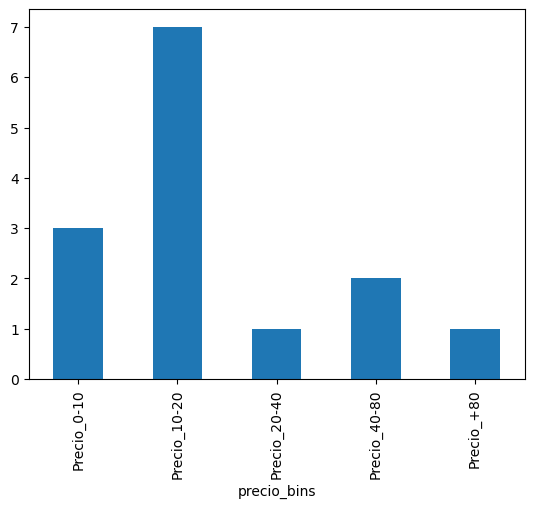

In [48]:
# Función para categorizar precios y generar un gráfico de barras
# Esto ayudará al usuario a decidir el rango de precio en el que se quiere mover
df = resultados_recomendaciones.iloc[1:] # estamos eliminando el vino introducido por el cliente
precio_a_categorias(df)

### 6.2_Aplicación algoritmo topsis



In [49]:
from scipy.stats import rankdata # para hacer un ranking de candidates

In [50]:
from funciones_topsis import *

In [51]:
resultados_recomendaciones

titulo  \
3624         jose pariente sauvignon blanc 2023   
3751  jose pariente sauvignon blanc 2022 magnum   
3752         jose pariente sauvignon blanc 2022   
2663                                    re 2015   
2188               silvano garci­a verdejo 2022   
1928                               aquiana 2018   
1929                               aquiana 2019   
3570  campo viejo viura-tempranillo blanco 2021   
3127                 matarromera prestigio 2019   
4784            pinna fidelis roble 2021 magnum   
1603                         grimau brut nature   
4789     carmelo rodero pago de valtarreña 2020   
709                             espectacle 2020   
4263               noelia bebelia albariño 2022   
2940                      manar dos seixas 2021   

                                                   link  precio  rating  \
3624  https://bodeboca.com/vino/jose-pariente-sauvig...   10.20     4.5   
3751  https://bodeboca.com/vino/jose-pariente-sauvig...   21.90     5.0   
3752  https://bodeboca.com/vino/jose-pariente-sauvig...   10.50     4.0   
2663                  https://bodeboca.com/vino/re-2015   17.90     NaN   
2188  https://bodeboca.com/vino/silvano-garcia-verde...    7.90     4.0   
1928             https://bodeboca.com/vino/aquiana-2018   14.90     3.3   
1929             https://bodeboca.com/vino/aquiana-2019   12.90     4.5   
3570  https://bodeboca.com/vino/campo-viejo-viura-te...    5.90     4.4   
3127  https://bodeboca.com/vino/matarromera-prestigi...   61.00     NaN   
4784  https://bodeboca.com/vino/pinna-fidelis-roble-...   17.75     3.9   
1603       https://bodeboca.com/vino/grimau-brut-nature    9.90     5.0   
4789  https://bodeboca.com/vino/carmelo-rodero-pago-...   53.90     4.3   
709           https://bodeboca.com/vino/espectacle-2020  119.90     NaN   
4263  https://bodeboca.com/vino/noelia-bebelia-albar...   14.95     4.0   
2940    https://bodeboca.com/vino/manar-dos-seixas-2021   17.50     NaN   

                                bodega           tipo  grado   anada  \
3624     bodegas bodegas-jose-pariente         blanco   13.0  2023.0   
3751     bodegas bodegas-jose-pariente         blanco   13.0  2022.0   
3752     bodegas bodegas-jose-pariente         blanco   13.0  2022.0   
2663            bodegas celler-tintore          tinto   13.5  2015.0   
2188            bodegas silvano-garcia         blanco   13.0  2022.0   
1928  bodegas bodegas-y-vinedos-merayo          tinto   14.5  2018.0   
1929  bodegas bodegas-y-vinedos-merayo          tinto   14.5  2019.0   
3570               bodegas campo-viejo         blanco   13.0  2021.0   
3127               bodegas matarromera  tinto reserva   15.0  2019.0   
4784             bodegas pinna-fidelis          tinto   14.0  2021.0   
1603                    bodegas grimau           cava   11.5  2013.0   
4789            bodegas bodegas-rodero          tinto   15.0  2020.0   
709        bodegas espectacle-montsant          tinto   15.0  2020.0   
4263            bodegas noelia-bebelia         blanco   13.2  2022.0   
2940        bodegas gallina-piel-wines         blanco   13.0  2021.0   

                                               variedad            origen  \
3624                               100% sauvignon blanc             rueda   
3751                               100% sauvignon blanc             rueda   
3752                               100% sauvignon blanc             rueda   
2663             garnacha, cariñena, cabernet sauvignon  conca de barberi   
2188                                       100% verdejo           jumilla   
1928                                       100% menci­a            bierzo   
1929                                       100% menci­a            bierzo   
3570                                 tempranillo, viura             rioja   
3127                                   100% tempranillo  ribera del duero   
4784                               100% tinta del pai­s  ribera del duero   
1603                   

In [52]:
# solicitar al usuario un precio minimo del vino
def solicitar_precio_min():
    """
  Función para solicitar al usuario el precio mínimo que desea.

  Retorno:
    Un valor flotante que representa el precio mínimo deseado.
  """
    while True:
        try:
            precio_min = float(input("Ingrese el precio mínimo que desea (en euros): "))
            if precio_min < 0:
                raise ValueError("El precio mínimo no puede ser negativo.")
            return precio_min
        except ValueError:
            print("Error: Debe ingresar un valor numérico válido para el precio mínimo.")


# solicitar al usuario un precio maximo del vino
def solicitar_precio_max(precio_min):
    """
  Función para solicitar al usuario el precio máximo que desea, considerando el precio mínimo.

  Argumento:
    precio_min: El precio mínimo previamente ingresado por el usuario.

  Retorno:
    Un valor flotante que representa el precio máximo deseado.
  """
    while True:
        try:
            precio_max = float(input("Ingrese el precio máximo que desea (en euros): "))
            if precio_max <= precio_min:
                raise ValueError("El precio máximo no puede ser menor o igual al precio mínimo.")
            return precio_max
        except ValueError:
            print("Error: Debe ingresar un valor numérico mayor que el precio mínimo.")

In [53]:
# solicitar al usuario un precio minimo y máximo del vino
precio_min=solicitar_precio_min()
precio_max = solicitar_precio_max(precio_min)
print(f"Rango de precio seleccionado: {precio_min:.2f} - {precio_max:.2f} euros")

Ingrese el precio mínimo que desea (en euros): 10
Ingrese el precio máximo que desea (en euros): 20
Rango de precio seleccionado: 10.00 - 20.00 euros


In [54]:
# estos filtros personalizados van a generar un dataframe sobre el que vamos a aplicar el algoritmo Topsis
# generar DataFrame al que aplicar topsis
def filtrar_por_precio(df, precio_min, precio_max):
    """
  Función para filtrar un DataFrame por rango de precios.

  Argumentos:
    df: El DataFrame a filtrar.
    precio_min: Precio mínimo del rango.
    precio_max: Precio máximo del rango.

  Retorno:
    DataFrame filtrado por rango de precios.
  """

  # Filtrar por rango de precios
    df_filtrado = df[(precio_min <= df["precio"]) & (df["precio"] <= precio_max)]

    vinos = df_filtrado[["titulo","link","tipo2","precio","rating"]]
    vinos = vinos.dropna()
    
    return vinos

In [55]:
vinos = filtrar_por_precio(df, precio_min, precio_max)
vinos

titulo  \
3752  jose pariente sauvignon blanc 2022   
1928                        aquiana 2018   
1929                        aquiana 2019   
4784     pinna fidelis roble 2021 magnum   
4263        noelia bebelia albariño 2022   

                                                   link   tipo2  precio  \
3752  https://bodeboca.com/vino/jose-pariente-sauvig...  blanco   10.50   
1928             https://bodeboca.com/vino/aquiana-2018   tinto   14.90   
1929             https://bodeboca.com/vino/aquiana-2019   tinto   12.90   
4784  https://bodeboca.com/vino/pinna-fidelis-roble-...   tinto   17.75   
4263  https://bodeboca.com/vino/noelia-bebelia-albar...  blanco   14.95   

      rating  
3752     4.0  
1928     3.3  
1929     4.5  
4784     3.9  
4263     4.0

In [56]:
df_topsis_pesos, df_ranking = topsis(vinos)

In [57]:
df_topsis_pesos

titulo       X 1       X 2
0  jose pariente sauvignon blanc 2022   0.26082   0.09038
1                        aquiana 2018  0.370116  0.074563
2                        aquiana 2019  0.320436  0.101677
3     pinna fidelis roble 2021 magnum   0.44091   0.08812
4        noelia bebelia albariño 2022  0.371358   0.09038

In [58]:
df_ranking

ranking_topsis                               $C^*$  \
0               1     pinna fidelis roble 2021 magnum   
1               2        noelia bebelia albariño 2022   
2               3                        aquiana 2018   
3               4                        aquiana 2019   
4               5  jose pariente sauvignon blanc 2022   

                                $S^*$                               $S^-$  
0                        aquiana 2018     pinna fidelis roble 2021 magnum  
1  jose pariente sauvignon blanc 2022        noelia bebelia albariño 2022  
2     pinna fidelis roble 2021 magnum                        aquiana 2018  
3                        aquiana 2019                        aquiana 2019  
4        noelia bebelia albariño 2022  jose pariente sauvignon blanc 2022

In [59]:
df_ranking.rename(columns={"$C^*$": "titulo"}, inplace=True)
df_combinado = vinos.merge(df_ranking[["ranking_topsis","titulo"]], how='left', on='titulo')
df_combinado = df_combinado.sort_values(by='ranking_topsis', ascending=True)  # Ordenar por 'ranking_topsis' de forma descendente
df_combinado2 = df_combinado.merge(df_topsis_pesos[["titulo", "X 1", "X 2"]], how='left', on='titulo')
df_combinado2

titulo  \
0     pinna fidelis roble 2021 magnum   
1        noelia bebelia albariño 2022   
2                        aquiana 2018   
3                        aquiana 2019   
4  jose pariente sauvignon blanc 2022   

                                                link   tipo2  precio  rating  \
0  https://bodeboca.com/vino/pinna-fidelis-roble-...   tinto   17.75     3.9   
1  https://bodeboca.com/vino/noelia-bebelia-albar...  blanco   14.95     4.0   
2             https://bodeboca.com/vino/aquiana-2018   tinto   14.90     3.3   
3             https://bodeboca.com/vino/aquiana-2019   tinto   12.90     4.5   
4  https://bodeboca.com/vino/jose-pariente-sauvig...  blanco   10.50     4.0   

   ranking_topsis       X 1       X 2  
0               1   0.44091   0.08812  
1               2  0.371358   0.09038  
2               3  0.370116  0.074563  
3               4  0.320436  0.101677  
4               5   0.26082   0.09038

### 6.3_Visualizacion

Vamos a tratar el dataframe para que añada las columnas "X 1" y "X 2" con los pesos y muestre los resultados según el ranking asignado

In [60]:
# Define la función para generar las etiquetas
def generar_etiquetas(df):
    """
  Función para generar las etiquetas personalizadas para cada punto.

  Argumentos:
    row: Una fila del DataFrame.

  Retorno:
    Un diccionario con las etiquetas "etiqueta_ranking" y "etiqueta_titulo".
  """
    return {
      "etiqueta_ranking": df["ranking_topsis"],
      "etiqueta_titulo": df["titulo"],
  }

In [61]:
# funcion para hacer el grafico con un rel plot explicando por codigo de color el tipo de vino y por tamaño el precio. Tambien asigna una etiqueta de ranking
def grafico_topsis(df):
    # paleta de color:
    color_vino = {'tinto': 'crimson','blanco': 'sandybrown','espumoso': 'royalblue','generoso':'purple','rosado': 'violet', 'vermouth': 'limegreen'}

    # Crea el diagrama de dispersión
    g = sns.relplot(
        x="X 1",
        y="X 2",
        hue="tipo2",
        size="precio",
        sizes=(50, 200),
        data=df,
        palette=color_vino,)

    # Añade etiquetas personalizadas a cada punto
    for i, row in df.iterrows():
        etiquetas = generar_etiquetas(row)
      # Separar el título en dos líneas
        titulo_linea_1 = etiquetas["etiqueta_titulo"][:len(etiquetas["etiqueta_titulo"]) // 2]
        titulo_linea_2 = etiquetas["etiqueta_titulo"][len(etiquetas["etiqueta_titulo"]) // 2:]

        plt.annotate(f"{titulo_linea_1}\n{titulo_linea_2}", (row["X 1"], row["X 2"]), textcoords="offset points", xytext=(0, 20), ha='left',rotation=45)
        plt.annotate(etiquetas["etiqueta_ranking"], (row["X 1"], row["X 2"]), textcoords="offset points", xytext=(0, 10), ha='center')

    # Establecer el texto del eje X
    plt.xlabel("Precio Ponderado") 
    # Establecer el texto del eje Y
    plt.ylabel("Ranking Ponderado") 
    # Muestra el plot
    return plt.show()

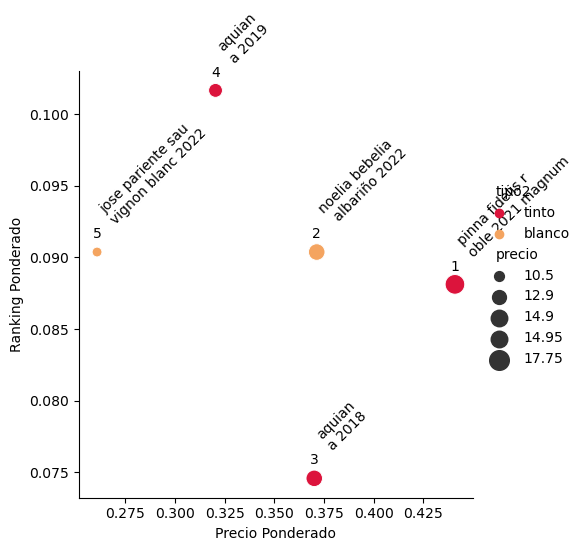

In [62]:
grafico_topsis(df_combinado2)

## 7.1 Visualizacion interactiva

In [63]:
def visualizacion_interactiva(df):
    """
    Crea un diagrama de dispersión para visualizar datos de vinos con diferentes opciones de personalización.

    Parámetros:
        df (pandas.DataFrame): El DataFrame que contiene los datos de los vinos.

    Devoluciones:
        plotly.Figure: El objeto de figura de Plotly que representa el diagrama de dispersión.
    """

    # Obtiene las columnas para el eje X y el eje Y
    x = df["X 1"]
    y = df["X 2"]

    # Definimos un mapeo de colores para los tipos de vinos
    color_map = {
        'tinto': 'crimson',
        'blanco': 'sandybrown',
        'espumoso': 'royalblue',
        'generoso': 'purple',
        'rosado': 'violet',
        'vermouth': 'limegreen'}

    # Define el tamaño de los puntos en función del ranking TOPSIS
    sizes = (df["ranking_topsis"].max() - df["ranking_topsis"]) / df["ranking_topsis"].max() * 20 + 5

    # Define el gráfico
    fig = go.Figure()

    # Agrega los puntos al gráfico
    for tipo in color_map.keys():
        datos_tipo = df[df["tipo2"] == tipo]
        fig.add_scatter(
            x=datos_tipo["X 1"],  # Corregido aquí
            y=datos_tipo["X 2"],  # Corregido aquí
            name=tipo,
            mode="markers",
            marker=dict(color=color_map[tipo], size=sizes, sizemode='diameter'),
            hoverinfo="text",
            text="**Tipo:** " + tipo + "<br>" + datos_tipo["titulo"] + "<br>Ranking TOPSIS: " + datos_tipo["ranking_topsis"].astype(str) + "<br>Precio: "+ datos_tipo["precio"].astype(str),  # Corregido aquí
        )

    # Personaliza el título y las etiquetas de los ejes
    fig.update_layout(
        title="Diagrama de dispersión de vinos",
        xaxis_title="Precio ponderado",
        yaxis_title="Ranking ponderado",
        legend_title="Tipos de Vinos",
    )

    # Muestra el gráfico y devuelve la figura
    return fig


In [64]:
visualizacion_interactiva(df_combinado2)

## 8. Funcion Topsis General

In [65]:
def topsis_general(df):
    # 1_Seleccionar vinos excluyendo el elegido por el usuario
    df2 = df.iloc[1:] 
    # 2_ Solicitar al usuario un precio minimo y máximo del vino
    precio_min=solicitar_precio_min()
    precio_max = solicitar_precio_max(precio_min)
    print(f"Rango de precio seleccionado: {precio_min:.2f} - {precio_max:.2f} euros")
    # 3_ filtrar DataFrame según el rango de precio definico por el usuario
    vinos = filtrar_por_precio(df2, precio_min, precio_max)
    # 4_aplicar TOPSIS
    df_topsis_pesos, df_ranking = topsis(vinos)
    # 5_combinar dataframes vinos, df_ranking y df_topsis_pesos
    df_ranking.rename(columns={"$C^*$": "titulo"}, inplace=True)
    df_combinado = vinos.merge(df_ranking[["ranking_topsis","titulo"]], how='left', on='titulo')
    df_combinado = df_combinado.sort_values(by='ranking_topsis', ascending=True)  # Ordenar por 'ranking_topsis' de forma descendente
    df_combinado2 = df_combinado.merge(df_topsis_pesos[["titulo", "X 1", "X 2"]], how='left', on='titulo')
    return visualizacion_interactiva(df_combinado2)

In [66]:
topsis_general(resultados_recomendaciones)


Ingrese el precio mínimo que desea (en euros): 10
Ingrese el precio máximo que desea (en euros): 20
Rango de precio seleccionado: 10.00 - 20.00 euros
